In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import gc

import numpy as np

sys.path.append("..")
from dm21cm.dm_params import DMParams

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

In [2]:
"""Main evolution function."""

import os
import sys
import logging

import numpy as np
from scipy import interpolate
from astropy.cosmology import Planck18
import astropy.units as u
import jax.numpy as jnp

import py21cmfast as p21c
from py21cmfast import cache_tools

sys.path.append(os.environ['DH_DIR']) # use branch test_dm21cm
from darkhistory.spec.spectrum import Spectrum

sys.path.append("..")
import dm21cm.physics as phys
from dm21cm.dh_wrappers import DarkHistoryWrapper, TransferFunctionWrapper
from dm21cm.utils import load_h5_dict
from dm21cm.data_cacher import Cacher
from dm21cm.profiler import Profiler

logging.getLogger().setLevel(logging.INFO)
logging.getLogger('21cmFAST').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [3]:
#===== utilities for evolve =====

def get_z_edges(z_max, z_min, zplusone_step_factor):
    z_s = [z_min]
    while z_s[-1] < z_max:
        z_s.append((z_s[-1] + 1.0) * zplusone_step_factor - 1.0)
    
    return np.clip(z_s[::-1], None, z_max)


def split_xray(phot_N, phot_eng):
    """Split a photon spectrum (N in bin) into bath and xray band."""

    ex_lo, ex_hi = 1e2, 1e4 # [eV]
    ix_lo = np.searchsorted(phot_eng, ex_lo) # i of first bin greater than ex_lo, excluded
    ix_hi = np.searchsorted(phot_eng, ex_hi) # i of first bin greater than ex_hi, included

    bath_N = np.array(phot_N).copy()
    xray_N = np.array(phot_N).copy()
    bath_N[ix_lo:ix_hi] *= 0
    xray_N[:ix_lo] *= 0
    xray_N[ix_hi:] *= 0
    
    return bath_N, xray_N


def gen_injection_boxes(z_next, p21c_initial_conditions):
    
    input_heating = p21c.input_heating(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z_next, init_boxes=p21c_initial_conditions, write=False)
    
    return input_heating, input_ionization, input_jalpha

global_astro_params = p21c.AstroParams(
    L_X = 0. # L_X = 10**0.
)

def p21c_step(perturbed_field, spin_temp, ionized_box,
             input_heating=None, input_ionization=None, input_jalpha=None):
    
    # Calculate the spin temperature, possibly using our inputs
    spin_temp = p21c.spin_temperature(
        perturbed_field = perturbed_field,
        previous_spin_temp = spin_temp,
        input_heating_box = input_heating,
        input_ionization_box = input_ionization,
        input_jalpha_box = input_jalpha,
        astro_params=global_astro_params,
    )
    
    # Calculate the ionized box
    ionized_box = p21c.ionize_box(
        perturbed_field = perturbed_field,
        previous_ionize_box = ionized_box,
        spin_temp = spin_temp,
        astro_params=global_astro_params,
    )
    
    # Calculate the brightness temperature
    brightness_temp = p21c.brightness_temperature(
        ionized_box = ionized_box,
        perturbed_field = perturbed_field,
        spin_temp = spin_temp
    )
    
    return spin_temp, ionized_box, brightness_temp

In [4]:
run_name = 'xc_ours'
z_start = 45.
z_end = 5.
zplusone_step_factor = 1.01
dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e0,
    sigmav = 1e-50,
    struct_boost_model = 'erfc 1e-3',
)
enable_elec = False
tf_version = '230629xc'

p21c_initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM = 32,
        BOX_LEN = 32 * 2, # [conformal Mpc]
        N_THREADS = 32,
    ),
    cosmo_params = p21c.CosmoParams(
        OMm = Planck18.Om0,
        OMb = Planck18.Ob0,
        POWER_INDEX = Planck18.meta['n'],
        SIGMA_8 = Planck18.meta['sigma8'],
        hlittle = Planck18.h,
    ),
    random_seed = 54321,
    write = True,
)

rerun_DH = False
clear_cache = True
use_tqdm = False
debug_flags = ['xraycheck']

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [ ]:
logging.info(f'Using 21cmFAST version {p21c.__version__}')

#===== cache and memory =====
p21c.config['direc'] = f"{os.environ['P21C_CACHE_DIR']}/{run_name}"
logging.info(f"Cache dir: {p21c.config['direc']}")
os.makedirs(p21c.config['direc'], exist_ok=True)
if clear_cache:
    cache_tools.clear_cache()
gc.collect()

#===== initialize =====
#--- physics parameters ---
p21c.global_params.Z_HEAT_MAX = z_start + 1e-10
p21c.global_params.ZPRIME_STEP_FACTOR = zplusone_step_factor
p21c.global_params.CLUMPING_FACTOR = 1.
EPSILON = 1e-6

abscs = load_h5_dict(f'../data/abscissas/abscs_{tf_version}.h5')
if not np.isclose(np.log(zplusone_step_factor), abscs['dlnz']):
    raise ValueError('zplusone_step_factor and tf_version mismatch')
dm_params.set_inj_specs(abscs)

box_dim = p21c_initial_conditions.user_params.HII_DIM
box_len = p21c_initial_conditions.user_params.BOX_LEN
cosmo = Planck18

#--- DarkHistory and transfer functions ---
dh_wrapper = DarkHistoryWrapper(
    dm_params,
    prefix = p21c.config[f'direc'],
)
tf_prefix = f"{os.environ['DM21CM_DATA_DIR']}/tf/{tf_version}"
tf_wrapper = TransferFunctionWrapper(
    box_dim = box_dim,
    abscs = abscs,
    prefix = tf_prefix,
    enable_elec = enable_elec,
)

#--- xray ---
xray_cacher = Cacher(data_path=f"{p21c.config['direc']}/xray_brightness.h5", cosmo=cosmo, N=box_dim, dx=box_len/box_dim)
xray_cacher.clear_cache()

#--- xraycheck ---
if 'xraycheck' in debug_flags:

    delta_cacher = Cacher(data_path=f"{p21c.config['direc']}/xraycheck_brightness.h5", cosmo=cosmo, N=box_dim, dx=box_len/box_dim, xraycheck=True)
    delta_cacher.clear_cache()

    L_X_numerical_factor = 1e80 # make float happy
    xray_eng_lo = 0.5 * 1000 # [eV]
    xray_eng_hi = 10.0 * 1000 # [eV]
    xray_i_lo = np.searchsorted(abscs['photE'], xray_eng_lo)
    xray_i_hi = np.searchsorted(abscs['photE'], xray_eng_hi)
    print('xray eng range', xray_i_lo, xray_i_hi)

    res_dict = np.load('../data/xraycheck/Interpolators.npz', allow_pickle=True)
    z_range, delta_range, r_range = res_dict['SFRD_Params']
    print('z_range', np.min(z_range), np.max(z_range))
    print('delta_range', np.min(delta_range), np.max(delta_range))
    print('r_range', np.min(r_range), np.max(r_range))

    cond_sfrd_table = res_dict['Cond_SFRD_Table']
    st_sfrd_table =  res_dict['ST_SFRD_Table']

    # Takes the redshift as `z`
    # The overdensity parameter smoothed on scale `R`
    # The smoothing scale `R` in units of Mpc
    # Returns the conditional PS star formation rate density in [M_Sun / Mpc^3 / s]
    Cond_SFRD_Interpolator = interpolate.RegularGridInterpolator((z_range, delta_range, r_range), cond_sfrd_table)

    # Takes the redshift as `z`
    # Returns the mean ST star formation rate density star formation rate density in [M_Sun / Mpc^3 / s]
    ST_SFRD_Interpolator = interpolate.interp1d(z_range, st_sfrd_table)

#--- redshift stepping ---
z_edges = get_z_edges(z_start, z_end, p21c.global_params.ZPRIME_STEP_FACTOR)

#===== initial step =====
perturbed_field = p21c.perturb_field(redshift=z_edges[0], init_boxes=p21c_initial_conditions)
spin_temp, ionized_box, brightness_temp = p21c_step(perturbed_field=perturbed_field, spin_temp=None, ionized_box=None)

dh_wrapper.evolve(end_rs=(1+z_start)*0.9, rerun=rerun_DH)
dh_wrapper.match(spin_temp, ionized_box)
phot_bath_spec = dh_wrapper.get_phot_bath(rs=1+z_edges[0])

#===== main loop =====
#--- trackers ---
if 'xraycheck' in debug_flags:
    i_xraycheck_loop_start = 0
else:
    i_xray_loop_start = 0 # where we start looking for annuli
records = []
profiler = Profiler()

z_iterator = range(len(z_edges)-1)
if use_tqdm:
    from tqdm import tqdm
    z_iterator = tqdm(z_iterator)

for i_z in z_iterator:

    if not use_tqdm:
        print(f'i_z={i_z}/{len(z_edges)-1} z={z_edges[i_z]:.2f}')

    z_current = z_edges[i_z]
    z_next = z_edges[i_z+1]
    dt = ( cosmo.age(z_next) - cosmo.age(z_current) ).to('s').value
    
    nBavg = phys.n_B * (1+z_current)**3 # [Bavg / (physical cm)^3]
    delta_plus_one_box = 1 + np.asarray(perturbed_field.density)
    rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+z_current)**3 # [eV/(physical cm)^3]
    x_e_box = np.asarray(1 - ionized_box.xH_box)
    inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * dm_params.struct_boost(1+z_current) / nBavg # [inj/Bavg]
    
    tf_wrapper.init_step(
        rs = 1 + z_current,
        delta_plus_one_box = delta_plus_one_box,
        x_e_box = x_e_box,
    )
    
    #===== photon injection and energy deposition =====
    #--- xray ---
    profiler.start()
    if 'xraycheck' in debug_flags:

        xraycheck_bath_dNdE = np.zeros((500,))

        emissivity_bracket_unif = 0.
        for i_z_shell in range(i_xraycheck_loop_start): # uniform injection
            z_shell = z_edges[i_z_shell]
            shell_dNdE = delta_cacher.spectrum_cache.get_spectrum(z_shell).dNdE

            delta_unif = 0. # just a number
            emissivity_bracket_unif = Cond_SFRD_Interpolator((z_donor, delta_unif, 512.-EPSILON)) # [M_Sun / Mpc^3 / s]
            if np.mean(emissivity_bracket_unif) > 0:
                emissivity_bracket_unif *= (ST_SFRD_Interpolator(z_donor) / np.mean(emissivity_bracket_unif)) # [M_Sun / Mpc^3 / s]
            z_shell = z_edges[i_z_shell]
            emissivity_bracket_unif *= (1 + delta_unif) / (phys.n_B * u.cm**-3).to('Mpc**-3').value * dt # [M_Sun / Bavg]
            emissivity_bracket_unif *= L_X_numerical_factor
            shell_dNdE *= emissivity_bracket_unif
            xraycheck_bath_dNdE += shell_dNdE # put in bath

        print('  np.mean(emissivity_bracket_unif)', np.mean(emissivity_bracket_unif))

        L_X_bath_spec = Spectrum(abscs['photE'], xraycheck_bath_dNdE, spec_type='dNdE', rs=1+z_current) # [counts / (keV Msun)]
        weight = jnp.ones_like(delta_plus_one_box)
        tf_wrapper.inject_phot(L_X_bath_spec, inject_type='xray', weight_box=weight) # inject bath

        print(f'i_xray_bath=0-{i_xraycheck_loop_start}')
        print('L_X_bath_spec.toteng', L_X_bath_spec.toteng())

        profiler.record('xraycheck bath')

        print(f'i_xray={i_xraycheck_loop_start}-{i_z}')
        
        emissivity_bracket = 0.
        for i_z_shell in range(i_xraycheck_loop_start, i_z):

            delta, L_X_spec, xraycheck_is_box_average, z_donor, R2 = delta_cacher.get_annulus_data(
                z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
            )
            delta = np.clip(delta, -1.0+EPSILON, 1.5-EPSILON)
            delta = np.array(delta)
            emissivity_bracket = Cond_SFRD_Interpolator((z_donor, delta, R2))
            if np.mean(emissivity_bracket) > 0:
                emissivity_bracket *= (ST_SFRD_Interpolator(z_donor) / np.mean(emissivity_bracket))
            z_shell = z_edges[i_z_shell]
            emissivity_bracket *= (1 + delta) / (phys.n_B * u.cm**-3).to('Mpc**-3').value * dt
            emissivity_bracket *= L_X_numerical_factor
            if xraycheck_is_box_average:
                i_xraycheck_loop_start = max(i_z_shell+1, i_xraycheck_loop_start)
            if ST_SFRD_Interpolator(z_donor) > 0.:
                tf_wrapper.inject_phot(L_X_spec, inject_type='xray', weight_box=jnp.asarray(emissivity_bracket))

        if i_z > 0:
            print('  np.mean(emissivity_bracket)', np.mean(emissivity_bracket))
            print('  L_X_spec.toteng', L_X_spec.toteng())

        profiler.record('xraycheck')

    else: # regular routine
        for i_z_shell in range(i_xray_loop_start, i_z):

            xray_brightness_box, xray_spec, is_box_average = xray_cacher.get_annulus_data(
                z_current, z_edges[i_z_shell], z_edges[i_z_shell+1]
            )
            # If we are smoothing on the scale of the box then dump to the global bath spectrum.
            # The deposition will happen with `phot_bath_spec`, and we will not revisit this shell.
            if is_box_average or 'uniform_xray' in debug_flags:
                phot_bath_spec.N += xray_brightness_box[0, 0, 0] * xray_spec.N
                i_xray_loop_start = max(i_z_shell+1, i_xray_loop_start)
            else:
                tf_wrapper.inject_phot(xray_spec, inject_type='xray', weight_box=xray_brightness_box)

        profiler.record('xray')

        #--- bath and homogeneous portion of xray ---
        tf_wrapper.inject_phot(phot_bath_spec, inject_type='bath')
        
        #--- dark matter (on-the-spot) ---
        tf_wrapper.inject_from_dm(dm_params, inj_per_Bavg_box)

        profiler.record('bath+dm')
    
    #===== 21cmFAST step =====
    if i_z > 0: # TEMPORARY: catch NaNs before they go into 21cmFAST
        if np.any(np.isnan(input_heating.input_heating)):
            raise ValueError('input_heating.input_heating has NaNs')
        if np.any(np.isnan(input_ionization.input_ionization)):
            raise ValueError('input_ionization.input_ionization has NaNs')
        if np.any(np.isnan(input_jalpha.input_jalpha)):
            raise ValueError('input_jalpha.input_jalpha has NaNs')
    perturbed_field = p21c.perturb_field(redshift=z_next, init_boxes=p21c_initial_conditions)    
    input_heating, input_ionization, input_jalpha = gen_injection_boxes(z_next, p21c_initial_conditions)
    tf_wrapper.populate_injection_boxes(input_heating, input_ionization, input_jalpha)
    
    spin_temp, ionized_box, brightness_temp = p21c_step(
        perturbed_field, spin_temp, ionized_box,
        input_heating = input_heating,
        input_ionization = input_ionization,
        input_jalpha = input_jalpha
    )

    profiler.record('21cmFAST')
    
    #===== prepare spectra for next step =====
    #--- bath (separating out xray) ---
    prop_phot_N, emit_phot_N = tf_wrapper.prop_phot_N, tf_wrapper.emit_phot_N # propagating and emitted photons have been stored in tf_wrapper up to this point, time to get them out
    emit_bath_N, emit_xray_N = split_xray(emit_phot_N, abscs['photE'])
    phot_bath_spec = Spectrum(abscs['photE'], prop_phot_N + emit_bath_N, rs=1+z_current, spec_type='N') # photons not emitted to the xray band are added to the bath (treated as uniform)
    phot_bath_spec.redshift(1+z_next)

    #--- xray ---
    if 'xraycheck' in debug_flags:
        attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=np.mean(x_e_box))) # convert from jax array
        delta_cacher.advance_spectrum(attenuation_arr, z_next)

        L_X_spec_prefac = 1e40 / np.log(4) * u.erg * u.s**-1 * u.M_sun**-1 * u.yr * u.keV**-1 # integrated luminosity
        L_X_spec_prefac /= L_X_numerical_factor
        print('L_X_spec_prefac', L_X_spec_prefac)
        # L_X (E * dN/dE) \propto E^-1
        L_X_dNdE = L_X_spec_prefac.to('1/Msun').value * (abscs['photE'] / 1000.) ** -2 / 1000. # convert to 1/eV
        L_X_dNdE[:xray_i_lo] *= 0.
        L_X_dNdE[xray_i_hi:] *= 0.
        L_X_spec = Spectrum(abscs['photE'], L_X_dNdE, spec_type='dNdE', rs=1+z_current) # [counts / (keV Msun)]
        print('np.max(L_X_spec.dNdE)', np.max(L_X_spec.dNdE))
        L_X_spec.switch_spec_type('N')
        L_X_spec.redshift(1+z_next)
        delta_cacher.cache(z_current, perturbed_field.density, L_X_spec)
        print('np.max(55.dNdE)', np.max(delta_cacher.spectrum_cache.get_spectrum(z_edges[55]).dNdE))
    
    else:
        attenuation_arr = np.array(tf_wrapper.attenuation_arr(rs=1+z_current, x=np.mean(x_e_box))) # convert from jax array
        xray_cacher.advance_spectrum(attenuation_arr, z_next)

        xray_spec = Spectrum(abscs['photE'], emit_xray_N, rs=1+z_current, spec_type='N') # [photon / Bavg]
        xray_spec.redshift(1+z_next)
        xray_tot_eng = np.dot(abscs['photE'], emit_xray_N)
        if xray_tot_eng == 0.:
            xray_rel_eng_box = np.zeros_like(tf_wrapper.xray_eng_box)
        else:
            xray_rel_eng_box = tf_wrapper.xray_eng_box / xray_tot_eng # [1 (relative energy) / Bavg]
        xray_cacher.cache(z_current, xray_rel_eng_box, xray_spec)
    
    #===== calculate and save some global quantities =====
    dE_inj_per_Bavg = dm_params.eng_per_inj * np.mean(inj_per_Bavg_box) # [eV per Bavg]
    dE_inj_per_Bavg_unclustered = dE_inj_per_Bavg / dm_params.struct_boost(1+z_current)
    
    record = {
        'z'   : z_next,
        'T_s' : np.mean(spin_temp.Ts_box), # [mK]
        'T_b' : np.mean(brightness_temp.brightness_temp), # [K]
        'T_k' : np.mean(spin_temp.Tk_box), # [K]
        'x_e' : np.mean(spin_temp.x_e_box), # [1]
        '1-x_H' : np.mean(1 - ionized_box.xH_box), # [1]
        'E_phot' : phot_bath_spec.toteng(), # [eV/Bavg]
        'dE_inj_per_B' : dE_inj_per_Bavg,
        'f_ion'  : np.mean(tf_wrapper.dep_box[...,0] + tf_wrapper.dep_box[...,1]) / dE_inj_per_Bavg_unclustered,
        'f_exc'  : np.mean(tf_wrapper.dep_box[...,2]) / dE_inj_per_Bavg_unclustered,
        'f_heat' : np.mean(tf_wrapper.dep_box[...,3]) / dE_inj_per_Bavg_unclustered,
    }
    records.append(record)

    profiler.record('prep_next')
    
#===== end of loop, save results =====
arr_records = {k: np.array([r[k] for r in records]) for k in records[0].keys()}
np.save(f"{os.environ['DM21CM_DIR']}/data/run_info/{run_name}_records", arr_records)

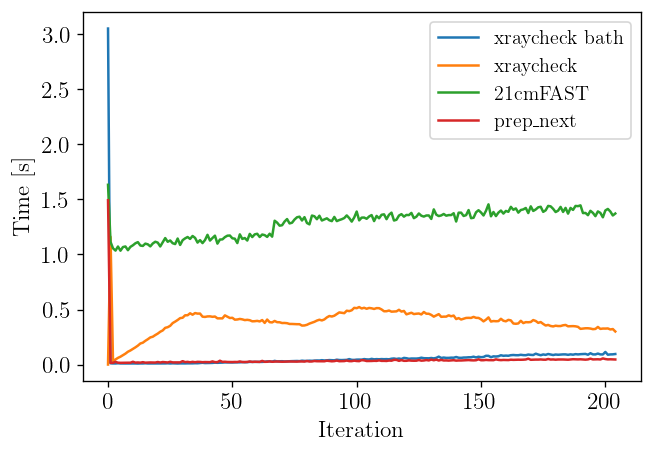

In [6]:
fig, ax = profiler.plot()

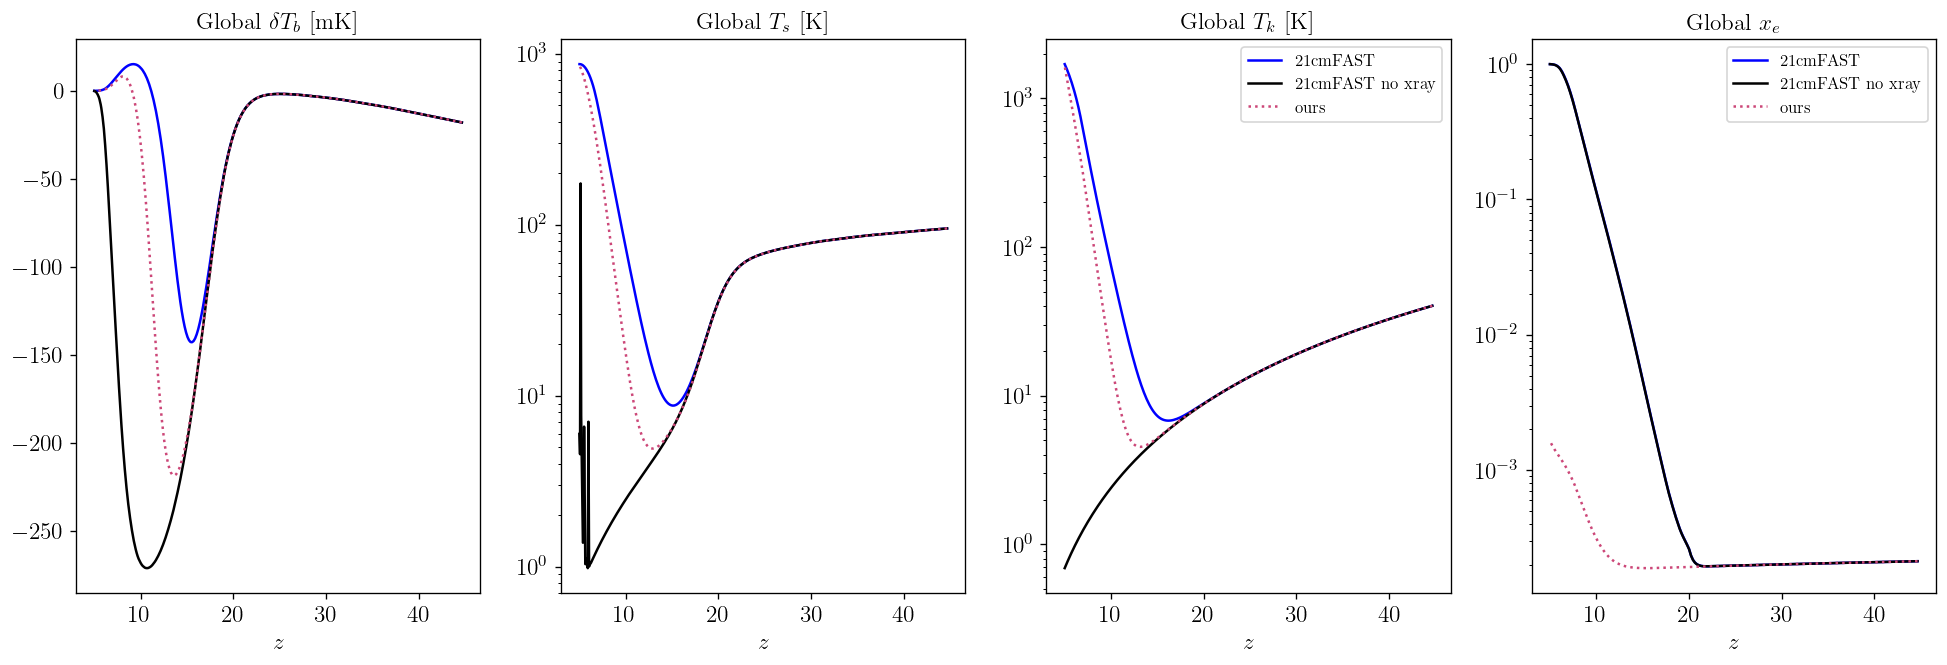

In [8]:
plot_options = {
    'base' : dict(color='b', ls='-'),
    'noxray' : dict(color='k', ls='-'),
    'ours' : dict(color=cms['plasma'](0.5), ls=':'),
    #'ours_nobath' : dict(color=cms['plasma'](0.8), ls=':'),
}
labels = {
    'T_b' : {
    },
    'T_s' : {
    },
    'T_k' : {
        'base' : '21cmFAST',
        'noxray' : '21cmFAST no xray',
        'ours' : 'ours',
    },
}

fig, axs = plt.subplots(1, 4, figsize=(20, 6))

for name in plot_options.keys():
    
    records = np.load(f'../data/run_info/xc_{name}_records.npy', allow_pickle=True).item()
    
    axs[0].plot(records['z'], records['T_b'], label=(labels['T_b'][name] if name in labels['T_b'].keys() else None), **plot_options[name])
    axs[1].plot(records['z'], records['T_s'], label=(labels['T_s'][name] if name in labels['T_s'].keys() else None), **plot_options[name])
    axs[2].plot(records['z'], records['T_k'], label=(labels['T_k'][name] if name in labels['T_k'].keys() else None), **plot_options[name])
    axs[3].plot(records['z'], records['x_e'], label=(labels['T_k'][name] if name in labels['T_k'].keys() else None), **plot_options[name])

axs[0].set(title=r'Global $\delta T_b$ [mK]', xlabel=r'$z$')
axs[1].set(title=r'Global $T_s$ [K]', xlabel=r'$z$')
axs[2].set(title=r'Global $T_k$ [K]', xlabel=r'$z$')
axs[3].set(title=r'Global $x_e$', xlabel=r'$z$')

axs[1].set(yscale='log')
axs[2].set(yscale='log')
axs[3].set(yscale='log')

axs[2].legend(fontsize=10)
axs[3].legend(fontsize=10)
#fig.savefig('../outputs/plots/global_evolution.pdf')

In [22]:
r1 = np.load(f'../data/run_info/xc_noxray_records.npy', allow_pickle=True).item()
r2 = np.load(f'../data/run_info/xc_ours_records.npy', allow_pickle=True).item()

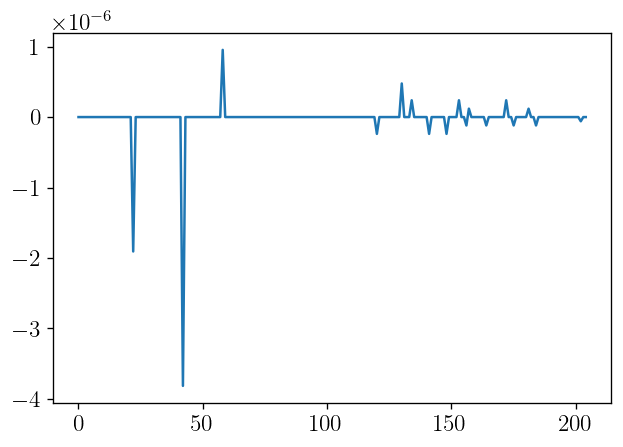

In [24]:
plt.plot(r1['T_k'] - r2['T_k'])